# Classical ML based Feature Selection - Per Sequence

### 1. Reading and Processing the stable radiomic features

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import numpy as np

In [2]:
OUT_PATH=r"./results"
FEAT_PATH = r"./features_StudySettings3D.csv"
INT_ICC_PATH = r"./stability_study_results/INT_Clinical/inout_plane_systematic_features_StudySettings3D.csv"
EXT_ICC_PATH = r"./stability_study_results/QIN_NonClinical_Dependent/inout_plane_systematic_features_StudySettings3D.csv"

SEQUENCE_BESTFILTER_PREFIX = {
    
                "t2w":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"],
               
                "adc":["original_shape","log-sigma-5-0-mm-3D_firstorder","square_glcm","exponential_glszm","exponential_glrlm","exponential_gldm","exponential_ngtdm"],
                
                "dce_win":["original_shape","logarithm_firstorder","logarithm_glcm","wavelet-HLL_glszm","logarithm_glrlm","square_gldm","logarithm_ngtdm"],
                
                "dce_wout":["original_shape","logarithm_firstorder","logarithm_glcm","logarithm_glszm","logarithm_glrlm","logarithm_gldm","logarithm_ngtdm"]
                
               }
ICC_THRESHOLD = 0.90

In [3]:
feat_df = pd.read_csv(FEAT_PATH)
int_icc_df = pd.read_csv(INT_ICC_PATH, index_col=0)
ext_icc_df = pd.read_csv(EXT_ICC_PATH, index_col=0)

In [4]:
selected_feats = {}

for i, row_int  in int_icc_df.iterrows():
    
    feature, _, c_down_int, _, sequence = row_int
       
    row_ext = ext_icc_df[ext_icc_df.feature==feature][ext_icc_df.sequence==sequence.split("_")[0]]#this is because for internal set there is dce_win and dce_wout, but for external there is only dce
    
    _, _, c_down_ext, _, _ = row_ext.values[0].tolist()

    if c_down_int>=ICC_THRESHOLD and c_down_ext>=ICC_THRESHOLD:
    
        prefices = SEQUENCE_BESTFILTER_PREFIX[sequence]

        for prefix in prefices:

            if prefix in feature:
                selected_feats.setdefault(sequence,[]).append(feature)
                

c:\sithin\myenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


### 2. Sort Features In an Orderly Way (Pearson correlation is dependent on that, Simple to Complex features)

In [5]:
def sort_feats(features):

    sorted_features = []

    for feat_type in ["shape","firstorder","glcm","glszm","glrlm","gldm","ngtdm"]:

        feats = sorted([feat for feat in features if feat_type in feat and feat not in sorted_features])

        sorted_features += feats
            
    return sorted_features
        

#### Sorting Features Per Sequence

In [6]:
for sequence in selected_feats.keys():
    
    selected_feats[sequence] = sort_feats(selected_feats[sequence])

In [7]:
dfs = {}

for sequence,feats in selected_feats.items():
    
    dfs[sequence] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])[feats]
    dfs[sequence]["label"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])['label']
    dfs[sequence]["id"] = feat_df[feat_df.sequence==sequence].sort_values(by=['id'])['id']
    
                

#### Class distribution

In [8]:
for sequence in selected_feats.keys():
    
    print(sequence,dfs[sequence]["label"].value_counts().to_dict())
    

t2w {0: 69, 1: 31}
adc {0: 69, 1: 31}
dce_win {0: 69, 1: 31}
dce_wout {0: 69, 1: 31}


### 3. Removing features with zero variance

In [9]:
var_threshold = 0.0

In [10]:
for sequence,features in selected_feats.items():
    
    feats,var_tags = zip(*((dfs[sequence][features].var()<=var_threshold).to_dict()).items())
    low_variance_features = list(np.array(feats)[np.array(var_tags)])
    
    selected_feats[sequence] = sort_feats(list(set(features) - set(low_variance_features)))
    
    print(f"Removed {len(low_variance_features)}; {len(selected_feats[sequence])} remaining")

    

Removed 0; 54 remaining
Removed 0; 79 remaining
Removed 0; 91 remaining
Removed 0; 97 remaining


### 4. Shape or Volume Correlated Feature Filtering

In [11]:
R_THRESHOLD = 0.85

In [12]:
#Removing Features Correlated with Shape

for sequence,feats in selected_feats.items():
    
    print(f"For {sequence}:")

    to_drop = []
    corr = dfs[sequence][feats].corr(method="pearson").abs()
    corr_dict = corr.to_dict()

    for feat in feats:

        if "original_shape" in feat: #original_shape_VoxelVolume will also be selected

            _to_drop = [key for key,val in corr_dict[feat].items() if val>=R_THRESHOLD and key not in to_drop]
            to_drop += _to_drop

    feats = list(set(feats)-set(to_drop))
    selected_feats[sequence] = sort_feats(feats)
    print(f"{len(to_drop)} highly shape correlated features deleted, {len(selected_feats[sequence])} features remaining")



For t2w:
16 highly shape correlated features deleted, 38 features remaining
For adc:
15 highly shape correlated features deleted, 64 features remaining
For dce_win:
14 highly shape correlated features deleted, 77 features remaining
For dce_wout:
13 highly shape correlated features deleted, 84 features remaining


### 5. Feautre filtering using pearson correlation coefficient per sequence

In [13]:
R_THRESHOLD = 0.85

In [14]:
for sequence,_df in dfs.items():
    
    corr = _df[selected_feats[sequence]].corr(method='pearson').abs()
    
    up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
    
    to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    
    selected_feats[sequence] = sort_feats(list(set(selected_feats[sequence]) - set(to_drop)))

    print(f"{len(to_drop)} highly correlated features deleted in sequence {sequence.upper()}, {len(selected_feats[sequence])} features remaining")
    

25 highly correlated features deleted in sequence T2W, 13 features remaining
46 highly correlated features deleted in sequence ADC, 18 features remaining
59 highly correlated features deleted in sequence DCE_WIN, 18 features remaining
67 highly correlated features deleted in sequence DCE_WOUT, 17 features remaining


#### Visualizing clusters using PCA and t-SNE

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [16]:
SEED = 0

In [17]:
def visualize(features, labels, n_components, sequence):
 
    features = features.copy()
    
    scaler = StandardScaler()#it is necessary to ensure that the scale is similar
    features = scaler.fit_transform(features)

    embedding = {}
    
    embedding["pca"] = PCA(n_components = n_components, random_state=SEED).fit_transform(features)
    embedding["tsne"] = TSNE(n_components=n_components,random_state=SEED).fit_transform(features)
        
    
    # initialising the plot
    
    fig = plt.figure()
    
    for i,key in enumerate(embedding.keys()):
    
        ax = fig.add_subplot(1,2,i+1)

        # plotting data
        ax.scatter(*zip(*embedding[key][np.where(labels==1)]),marker='o',color='r',s=10,alpha=0.7,label='Class-1')
        ax.scatter(*zip(*embedding[key][np.where(labels==0)]),marker='o',color='g',s=10,alpha=0.3,label='Class-0')
        ax.set_title(f"{sequence}-{key}")
        ax.legend()

    

    plt.show
    

c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\sithin\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change

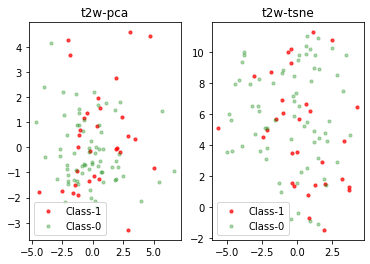

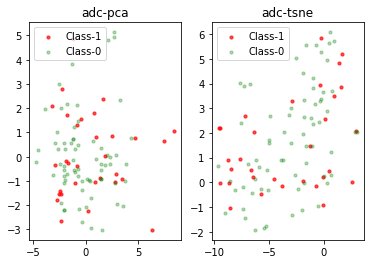

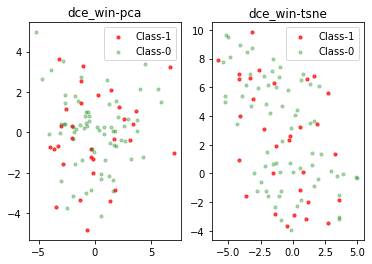

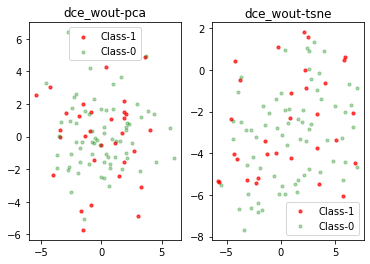

In [18]:
num_components = 2

for sequence in ["t2w","adc","dce_win","dce_wout"]:
    
    feats = dfs[sequence][selected_feats[sequence]].to_numpy()
    labels = dfs[sequence]["label"].to_numpy()
    
    visualize(feats, labels, num_components,sequence)

### 6. Feature Selection using classical ML Models using Backward Elimination Technique

Linear Model: LogisticRegression

Non Linear Model: RandomForestClassifier & SVC

In [19]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)#because of xgboost warnings

In [20]:

from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import time

#import xgboost as xgb
# from boruta import BorutaPy
# from sklearn.feature_selection import RFECV

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

#### Backward SequentialFeatureSelector Function

In [21]:
def run_bsfs(df, estimator, filtered_features):
    
    n = len(filtered_features)
    rank_dict = {}
    
    pbar = tqdm(range(n-1),desc=f"Running Backwards SFS with {estimator.__class__.__name__}", position=0)
    
    while n>1:
    
        X = df[filtered_features].to_numpy()
        y = df["label"].to_numpy().ravel()

        sfs_pipeline = make_pipeline(StandardScaler(), SFS(estimator, n_features_to_select=n-1, direction='backward', scoring="roc_auc", cv=rskf))
        sfs_pipeline.fit(X,y)
          

        eliminated_feature = np.array(filtered_features)[~sfs_pipeline['sequentialfeatureselector'].support_][0]
        rank_dict[eliminated_feature] = n

        filtered_features = np.array(filtered_features)[sfs_pipeline['sequentialfeatureselector'].support_]

        n -= 1
        
        pbar.update()
    
    rank_dict[filtered_features[0]] = n
        
        
    return rank_dict
    

In [22]:
out_path = os.path.join(OUT_PATH,"per_sequence")
if not os.path.exists(out_path):
    os.makedirs(out_path)
    

In [23]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=100,random_state=0)

estimators = [
    LogisticRegression(penalty='none'),
    SVC(),
    RandomForestClassifier()
]



### 7. Compute the ranks and export them

Each estimator will generate a rank dataframe for each sequence separately and then they are merged and sorted based on the ranking

We have used 3 estimators, so ranks generated by each estimator are stored inside rank_dfs dictionary

Sorting is done for correlation analysis

In [24]:
if not os.path.exists(os.path.join(out_path,"rank_dfs.npy")):
    
    rank_dfs = {}
    exe_stat = {}

    for estimator in estimators:
        
        print(f"Computing rank of estimator - {estimator.__class__.__name__}")

        rank_dfs[estimator.__class__.__name__] = []
        exe_stat[estimator.__class__.__name__] = {}

        for sequence,features in selected_feats.items():

            print(f"Processing {sequence}")

            start_time = time.time()

            rank_dict = run_bsfs(dfs[sequence],estimator, features)
            rank_dict = dict(sorted(rank_dict.items(), key=lambda item: item[1]))
            feats,ranks = zip(*rank_dict.items())

            rank_df = pd.DataFrame.from_dict({"feature":list(feats), "rank":list(ranks), "sequence":[sequence]*len(features), "merged_feature":[sequence+"_"+feat for feat in feats]})
            
            rank_dfs[estimator.__class__.__name__].append(rank_df)
            exe_stat[estimator.__class__.__name__][sequence] = (time.time() - start_time)
            
        rank_dfs[estimator.__class__.__name__] = pd.concat(rank_dfs[estimator.__class__.__name__]).sort_values(by=["rank"])


    np.save(os.path.join(out_path,"exe_stat.npy"),exe_stat)
    np.save(os.path.join(out_path,"rank_dfs.npy"), rank_dfs)

else:
    
    rank_dfs = np.load(os.path.join(out_path,"rank_dfs.npy"), allow_pickle=True).item()
    exe_stat = np.load(os.path.join(out_path,"exe_stat.npy"), allow_pickle=True).item()
    
    
for estimator_name,exe_time in exe_stat.items():
    
    print(f"{estimator_name} => Execution Time:{exe_time}")
    
    print("\n")


LogisticRegression => Execution Time:{'t2w': 203.43559980392456, 'adc': 530.0274002552032, 'dce_win': 476.9047999382019, 'dce_wout': 524.3803999423981}


SVC => Execution Time:{'t2w': 67.16739988327026, 'adc': 128.03200006484985, 'dce_win': 130.78460001945496, 'dce_wout': 114.55279994010925}


RandomForestClassifier => Execution Time:{'t2w': 3675.824202299118, 'adc': 6980.980010271072, 'dce_win': 7073.5441999435425, 'dce_wout': 6278.246799707413}


autoencoder => Execution Time:{'t2w': 625.2040584087372, 'adc': 639.7319610118866, 'dce_win': 647.8577082157135, 'dce_wout': 652.7266817092896}




### 8. Create a merged_df for each estimator based on rank_df features

For correlation analysis

In [25]:
merged_dfs = {}

In [26]:
for estimator in estimators:
    
    merged_dfs[estimator.__class__.__name__] = {}
    
    rank_df = rank_dfs[estimator.__class__.__name__] 
    
    for i,row in rank_df.iterrows():
        merged_dfs[estimator.__class__.__name__][row.sequence+"_"+row.feature] = dfs[row.sequence].sort_values(by=["id"])[row.feature].values
        
    merged_dfs[estimator.__class__.__name__]["id"] = dfs[row.sequence].sort_values(by=["id"])["id"].values
    merged_dfs[estimator.__class__.__name__]["label"] = dfs[row.sequence].sort_values(by=["id"])["label"].values
    
    merged_dfs[estimator.__class__.__name__] = pd.DataFrame.from_dict(merged_dfs[estimator.__class__.__name__])



### 9. Remove correlated features within the rank df associated with each estimator

In [27]:
R_THRESHOLD = 0.85

for estimator in estimators:
    
    print(f"For estimator {estimator.__class__.__name__}")
    
    merged_features = rank_dfs[estimator.__class__.__name__].merged_feature.to_list()
    
    corr = merged_dfs[estimator.__class__.__name__][merged_features].corr(method="pearson").abs()#order matters actually here
    up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))
    to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
    merged_features_filtered = list(set(merged_features)-set(to_drop))
    
    print(f"{len(to_drop)} highly correlated features deleted, {len(merged_features_filtered)} features remaining")

    rank_df = rank_dfs[estimator.__class__.__name__]
    rank_df = rank_df[rank_df.merged_feature.isin(merged_features_filtered)].sort_values(by=["rank"])

    if not os.path.exists(os.path.join(out_path,f"{estimator.__class__.__name__}.csv")):
        rank_df.to_csv(os.path.join(out_path,f"{estimator.__class__.__name__}.csv"),index=False)


For estimator LogisticRegression
0 highly correlated features deleted, 66 features remaining
For estimator SVC
0 highly correlated features deleted, 66 features remaining
For estimator RandomForestClassifier
0 highly correlated features deleted, 66 features remaining


### 10. Signature Selection and Validation using classical ML models

In [28]:
if os.path.exists(os.path.join(OUT_PATH,"signatures_sequence.csv")):
    signatures = pd.read_csv(os.path.join(OUT_PATH,"signatures_sequence.csv"))
else:
    signatures = pd.DataFrame.from_dict({})

In [29]:
NUM_FEATS = 4

In [30]:
for estimator in estimators:
    
    rank_df = pd.read_csv(os.path.join(out_path,f"{estimator.__class__.__name__}.csv"))
    
    radiomics_signature = rank_df.merged_feature.to_list()[:NUM_FEATS]
    
    X = merged_dfs[estimator.__class__.__name__][radiomics_signature].to_numpy()
    y = merged_dfs[estimator.__class__.__name__]["label"].to_numpy().ravel()
    
    estimator_pipeline = make_pipeline(StandardScaler(),estimator)
    results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc"],verbose=1,cv=rskf)
    
    roc_auc = results["test_roc_auc"]
    
    print(f"Estimator:{estimator.__class__.__name__}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}")
    print(f"Selected Features:{radiomics_signature}")
    
    signatures["BSFS_"+estimator.__class__.__name__] = radiomics_signature
    
    print("\n")
    
signatures.to_csv(os.path.join(OUT_PATH,"signatures_sequence.csv"),index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:LogisticRegression, roc_auc:0.57+-0.088
Selected Features:['t2w_logarithm_glszm_SizeZoneNonUniformity', 'dce_wout_logarithm_firstorder_InterquartileRange', 'dce_win_logarithm_firstorder_90Percentile', 'adc_log-sigma-5-0-mm-3D_firstorder_10Percentile']




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimator:SVC, roc_auc:0.68+-0.087
Selected Features:['t2w_logarithm_glszm_LargeAreaEmphasis', 'dce_wout_logarithm_glrlm_LongRunLowGrayLevelEmphasis', 'dce_win_logarithm_firstorder_10Percentile', 'adc_exponential_glszm_ZonePercentage']


Estimator:RandomForestClassifier, roc_auc:0.75+-0.077
Selected Features:['t2w_logarithm_glcm_Idmn', 'dce_wout_logarithm_ngtdm_Busyness', 'dce_win_logarithm_ngtdm_Busyness', 'adc_exponential_glszm_LargeAreaEmphasis']




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   51.4s finished


# Permutation Test

In [31]:
from sklearn.model_selection import permutation_test_score

In [54]:
export_path = r"C:\Sithin\autoencoder\permutation_results\per-sequence"
if not os.path.exists(export_path):
    os.makedirs(export_path)

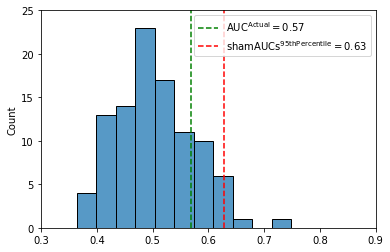

Estimator:LogisticRegression, Actual roc-auc: 0.5690961791831357, Range of sham roc-aucs:((0.3641686429512517, 0.7489209486166007)), p-value:0.18811881188118812, Distance:-0.05879986824769434


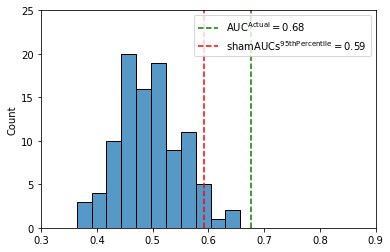

Estimator:SVC, Actual roc-auc: 0.676129117259552, Range of sham roc-aucs:((0.3639472990777339, 0.6572318840579711)), p-value:0.009900990099009901, Distance:0.08325612648221337


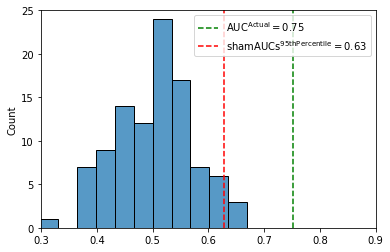

Estimator:RandomForestClassifier, Actual roc-auc: 0.7515494071146246, Range of sham roc-aucs:((0.29676811594202895, 0.6695480895915679)), p-value:0.009900990099009901, Distance:0.12302651515151519


In [55]:
if not os.path.exists(os.path.join(out_path,"bsfs_permutation_test.npy")):
    results = {}
    for estimator in estimators:
    
        radiomics_signature = signatures["BSFS_"+estimator.__class__.__name__].to_list()

        X = merged_dfs[estimator.__class__.__name__][radiomics_signature]
        y = merged_dfs[estimator.__class__.__name__]["label"].to_numpy().ravel()

        estimator_pipeline = make_pipeline(StandardScaler(), estimator)
        mean_rocauc, permuted_rocaucs, p_value = permutation_test_score(estimator_pipeline, X, y, scoring="roc_auc",verbose=1,cv=rskf)

        results[estimator.__class__.__name__] = {"p_value":p_value,"mean_auc":mean_rocauc,"permuted_aucs":permuted_rocaucs}
        
    np.save(os.path.join(out_path,"bsfs_permutation_test.npy"),results)
    
else:
    results = np.load(os.path.join(out_path,"bsfs_permutation_test.npy"),allow_pickle=True).item()
    

for estimator in results:
    
    p_value = results[estimator]["p_value"]
    mean_rocauc = results[estimator]["mean_auc"]
    permuted_rocaucs = results[estimator]["permuted_aucs"]
    
    params = {'mathtext.default':'regular'}
    plt.rcParams.update(params)
    
    fig = plt.figure()
    ax = fig.gca()
    
    sns.histplot(permuted_rocaucs, ax=ax)
    ax.set_xlim(0.3,0.9)
    ax.set_ylim(0,25)
    plt.axvline(mean_rocauc, label="$AUC^{Actual}$"+f"$={mean_rocauc:0.2f}$", color='g', ls='--')
    
    percentile95 = np.percentile(permuted_rocaucs, 95)
    
    plt.axvline(percentile95, label="$shamAUCs^{95th Percentile}$"+f"$={percentile95:0.2f}$", color='r', ls='--')
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(export_path,f"control-{estimator}.png"),dpi=300)
    plt.show()

    distance = mean_rocauc - percentile95#np.percentile(permuted_rocaucs, 95)
    
    

    print(f"Estimator:{estimator}, Actual roc-auc: {mean_rocauc}, Range of sham roc-aucs:({min(permuted_rocaucs),max(permuted_rocaucs)}), p-value:{p_value}, Distance:{distance}")
    


# Forward SequentialFeatureSelector

In [ ]:
# def run_fsfs(df, estimator, filtered_features):
    
#     rank_dict = {}
    
#     _filtered_features = list(filtered_features)
    
#     n = len(filtered_features)
#     pbar = tqdm(range(n),desc="Running Forward SFS", position=0)
    
#     for i in range(n-1):
    
#         X = df[filtered_features].to_numpy()
#         y = df["label"].to_numpy().ravel()

#         sfs_pipeline = make_pipeline(StandardScaler(), SFS(estimator, n_features_to_select=1, direction='forward', scoring="roc_auc", cv=rskf))
#         sfs_pipeline.fit(X,y)

#         selected_feature = np.array(filtered_features)[sfs_pipeline['sequentialfeatureselector'].support_][0]
#         rank_dict[selected_feature] = i+1

#         filtered_features = np.array(filtered_features)[~sfs_pipeline['sequentialfeatureselector'].support_]

        
#         pbar.update()
    
    
    
#     final_feature = list(set(_filtered_features) - set(rank_dict.keys()))[0]
#     rank_dict[final_feature] = n
        
        
#     return rank_dict
    

In [ ]:
# R_THRESHOLD = 0.85

# for estimator in estimators:
    
#     if not os.path.exists(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv")):
        
#         rank_dict = {"feature":[],"rank":[]}
    
#         for sequence,features in filtered_features.items():
            
#             _rank_dict = run_fsfs(df[sequence],estimator, features)
#             _rank_dict = dict(sorted(_rank_dict.items(), key=lambda item: item[1]))
            
#             for feat,rank in _rank_dict.items():
#                 rank_dict["feature"].append(sequence+"_"+feat)
#                 rank_dict["rank"].append(rank)


#         rank_df = pd.DataFrame.from_dict(rank_dict)
#         rank_df.to_csv(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv"),index=False) 
#     else: 
#         rank_df = pd.read_csv(os.path.join(out_path,f"FSFS-{estimator.__class__.__name__}.csv"))
        
#     selected_features = rank_df[rank_df["rank"]==1].feature.to_list()
        
#     #remove correlated features
    
#     corr = merged_df[selected_features].corr(method="pearson").abs()#order matters actually here
#     up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
#     to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
#     selected_features = list(set(selected_features)-set(to_drop))
    
#     print(f"{len(to_drop)} highly correlated features deleted, {len(selected_features)} features remaining")
    
#     X = merged_df[selected_features].to_numpy()
#     y = merged_df["label"].to_numpy().ravel()

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator =True)
    
#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(selected_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{selected_features}")

# Boruta Method

In [ ]:
# def get_feat_rank(df, feats, estimator):
    
#     print(feats)
    
#     X = df[feats].to_numpy()
#     y = df["label"].to_numpy().ravel()
    
#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator=True)

#     feat_importance = dict(zip(feats,[[] for i in range(len(feats))]))

#     for _estimator in results["estimator"]:
#         _feat_importance = _estimator[estimator.__class__.__name__.lower()].coef_.ravel() if estimator.__class__.__name__.lower()=="logisticregression" else _estimator[estimator.__class__.__name__.lower()].feature_importances_.ravel()
#         for feat,coef in zip(feats, _feat_importance):
#             feat_importance[feat].append(coef)

#     for feat,coef_list in feat_importance.items():
#         feat_importance[feat]=np.abs(coef_list).mean()
        
#     feat_rank = {}

#     for i,(feat,coef) in enumerate(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)):
#         feat_rank[feat] = i+1
        
#     return feat_rank

    

In [ ]:
# rank_dict = {"feature":[],"rank":[]}

# estimator = RandomForestClassifier()

# if not os.path.exists(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv")):
    
#     boruta_fs = BorutaPy(estimator, n_estimators='auto', verbose=2, random_state=1)
    
#     for sequence,features in filtered_features.items():

#         X = StandardScaler().fit_transform(df[sequence][features].to_numpy())
#         y = df[sequence]["label"].to_numpy().ravel()   

#         boruta_fs.fit(X,y)

#         boruta_features = np.array(features)[boruta_fs.support_]#+list(np.array(features)[boruta_fs.support_weak_]))
        
#         if len(boruta_features)>0:
        
#             feat_rank = get_feat_rank(df[sequence], boruta_features, estimator)

#             for feat,rank in zip(features, boruta_fs.ranking_):
#                 rank_dict["feature"].append(sequence+"_"+feat)
#                 if feat in feat_rank:
#                     rank_dict["rank"].append(feat_rank[feat])
#                 else:
#                     rank_dict["rank"].append(rank + len(boruta_features)-1)

#     rank_df = pd.DataFrame.from_dict(rank_dict)
#     rank_df.to_csv(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv"),index=False) 

# else:
#     rank_df = pd.read_csv(os.path.join(out_path,f"BORUTA-{estimator.__class__.__name__}.csv"))

# boruta_features = rank_df[rank_df["rank"]==1].feature.to_list()

# for estimator in estimators:

#     X = merged_df[boruta_features]

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator =True)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(boruta_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{boruta_features}")


# RFECV

In [ ]:
# def get_feat_rank(df, feats, estimator):
    
#     X = df[feats].to_numpy()
#     y = df["label"].to_numpy().ravel()
    
#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator=True)

#     feat_importance = dict(zip(feats,[[] for i in range(len(feats))]))

#     for _estimator in results["estimator"]:
#         _feat_importance = _estimator[estimator.__class__.__name__.lower()].coef_.ravel() if estimator.__class__.__name__.lower()=="logisticregression" else _estimator[estimator.__class__.__name__.lower()].feature_importances_.ravel()
#         for feat,coef in zip(feats, _feat_importance):
#             feat_importance[feat].append(coef)

#     for feat,coef_list in feat_importance.items():
#         feat_importance[feat]=np.abs(coef_list).mean()
        
#     feat_rank = {}

#     for i,(feat,coef) in enumerate(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)):
#         feat_rank[feat] = i+1
        
#     return feat_rank

    

In [ ]:
# R_THRESHOLD = 0.85

# for estimator in estimators:
    
#     if not os.path.exists(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv")):
        
#         rank_dict = {}
    
#         for sequence,features in filtered_features.items():

#             X = df[sequence][features].to_numpy()
#             y = df[sequence]["label"].to_numpy().ravel()
            
#             rfecv_pipeline = make_pipeline(StandardScaler(), RFECV(estimator,cv=rskf,scoring='roc_auc'))
#             rfecv_pipeline.fit(X,y)
            
#             rfecv_features = np.array(features)[rfecv_pipeline['rfecv'].support_]
#             feat_rank = get_feat_rank(df[sequence], rfecv_features, estimator)
            
#             for feat,rank in zip(features, rfecv_pipeline['rfecv'].ranking_):
                
#                 rank_dict[sequence+"_"+feat] = feat_rank[feat] if feat in feat_rank else rank+len(rfecv_features)-1
            
    
#         rank_dict = dict(sorted(rank_dict.items(), key=lambda item: item[1]))
#         feats,ranks = zip(*rank_dict.items())
#         rank_dict = {"feature":list(feats),"rank":list(ranks)}
#         rank_df = pd.DataFrame.from_dict(rank_dict)
#         rank_df.to_csv(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv"),index=False) 
#     else: 
#         rank_df = pd.read_csv(os.path.join(out_path,f"RFECV-{estimator.__class__.__name__}.csv"))
        
#     selected_features = rank_df[rank_df["rank"]==1].feature.to_list()
        
#     #remove correlated features
    
#     corr = merged_df[selected_features].corr(method="pearson").abs()#order matters actually here
#     up_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
#     to_drop = [column for column in up_tri.columns if any(up_tri[column] >= R_THRESHOLD)]
#     selected_features = list(set(selected_features)-set(to_drop))
    
#     print(f"{len(to_drop)} highly correlated features deleted, {len(selected_features)} features remaining")
    
#     X = merged_df[selected_features].to_numpy()
#     y = merged_df["label"].to_numpy().ravel()

#     estimator_pipeline = make_pipeline(StandardScaler(), estimator)
#     results = cross_validate(estimator_pipeline, X, y, scoring=["roc_auc","accuracy"],verbose=1,cv=rskf,return_estimator =True)
    
#     roc_auc = results["test_roc_auc"]
#     acc = results["test_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(selected_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}")
#     print(f"Selected Features:{selected_features}")

In [ ]:
# ensemble = ClassifierEnsemble(estimators)
# ensemble.fit(merged_df,rank_dict,rskf)
    
    
#     temp_dict = dict(zip(rank_dict["feature"],rank_dict["rank"]))
#     temp_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1]))
#     rank_dict = {"feature":list(temp_dict.keys()),"rank":list(temp_dict.values())}
#     rank_df = pd.DataFrame.from_dict(rank_dict)
#     rank_df.to_csv(os.path.join(out_path,f"{estimator.__class__.__name__}.csv"),index=False)
    
#     print("Classifier Fusion: Per Sequence Ensemble Model")
    
#     estimators = []
#     for sequence, rank_dict in sequence_rank_dict.items():
        
        
    
    
    
#     rfecv_features = rank_df[rank_df["rank"]==1].feature.to_list()
#     X = merged_df[rfecv_features]
#     estimator_pipeline = make_pipeline(StandardScaler(),estimator)
#     results = cross_validate(estimator_pipeline,X,y,scoring=["roc_auc","balanced_accuracy"],verbose=1,cv=rskf)

#     roc_auc = results["test_roc_auc"]
#     acc = results["test_balanced_accuracy"]

#     print(f"Estimator:{estimator.__class__.__name__}, feat_count:{len(rfecv_features)}, roc_auc:{roc_auc.mean():0.2}+-{roc_auc.std():0.2}, accuracy:{acc.mean():0.2}+-{acc.std():0.2}, likelihood:{likelihood.mean():0.2}+-{likelihood.std():0.2}")
#     print(f"Selected Features:{rfecv_features}")


In [ ]:
# class SequenceEnsemble:
    
#     def __init__(self, estimator):
        
#         self.estimator = estimator
        
        
#     def fit(self, merged_df, rank_dict, cv):
        
#         roc_auc_hist = []
#         acc_hist = []

#         y = merged_df["label"].to_numpy().ravel()

#         for train_index, val_index in cv.split(y,y):

#             y_preds = []

#             for sequence, _rank_dict in rank_dict.items():

#                 _rank_df = pd.DataFrame.from_dict(_rank_dict)

#                 selected_feats = _rank_df.feature[_rank_df[estimator.__class__.__name__+"_rank"]==1].to_list()
#                 selected_feats = [sequence+"_"+feat for feat in selected_feats]

#                 X = merged_df[selected_feats].to_numpy()

#                 X_train, y_train = X[train_index], y[train_index]
#                 X_val, y_val = X[val_index], y[val_index]

#                 estimator_pipeline = make_pipeline(StandardScaler(),self.estimator)
#                 estimator_pipeline.fit(X_train,y_train)
#                 pred = estimator_pipeline.predict_proba(X_val)

#                 y_preds.append(pred)


#             y_true = y[val_index] 
#             y_pred = np.array(y_preds).mean(axis=0)

#             acc = balanced_accuracy_score(y_true, y_pred.argmax(axis=1))
#             roc_auc = roc_auc_score(y_true,y_pred[:,1])

#             acc_hist.append(acc)
#             roc_auc_hist.append(roc_auc)

#         return np.array(roc_auc_hist), np.array(acc_hist)


                
             
        
        
                
        
                